In [1]:
# Classificação Multiclasse com SVM - Prevendo Gastos com Cartão de Crédito em 3 Categorias

# Obs: Caso tenha problemas com a acentuação, consulte este link:
# https://support.rstudio.com/hc/en-us/articles/200532197-Character-Encoding

# Definindo o diretório de trabalho
getwd()
#setwd("~/Dropbox/DSA/MachineLearning2.0/Cap11/R")

[1] "C:/Users/cassi/OneDrive/Programação/DSA/MachineLearning2.0/Cap11-R/R"

In [ ]:
####  Definido o Problema de Negócio #### 

# A identificação e a capacidade de classificar os clientes com base nos gastos sempre foram uma área de 
# interesse para instituições bancárias e empresas de cartão de crédito. É um aspecto importante no 
# gerenciamento de relacionamento com o cliente e ajuda a aumentar a receita com clientes existentes. Várias 
# tentativas foram feitas a esse respeito. Os emissores de cartões de crédito tradicionalmente têm como alvo 
# os consumidores usando informações sobre seus comportamentos e dados demográficos. 

# Nosso trabalho é classificar os clientes de cartão de crédito de acordo com seu comportamento de gastos. 
# A segmentação é um aspecto importante na compreensão do cliente e na execução de campanhas de marketing 
# eficazes e rentáveis. Usaremos o SVM como nosso modelo.

# Os dados demográficos, os detalhes sobre emprego e o estilo de vida dos clientes desempenham um papel vital na 
# maneira como eles gastam. Existem fatores ocultos, bem como semelhança com as compras. A máquina de vetores 
# de suporte pode ser usada para problemas de regressão e classificação. 

# Usaremos SVM com Kernel Linear Multiclasse como nosso modelo proposto para classificar a variável target. 
# No entanto, também avaliaremos outros Kernels, como RBF e Polinomial, para uma variedade de hiperparâmetros. 
# Também levamos em consideração o viés no dados.

# Fonte dos dados: https://sorry.vse.cz/~berka/ (dados anônimos)

In [2]:
# Pacotes
install.packages("gains")
install.packages("pROC")
install.packages("ROSE")
install.packages("mice")
library(dplyr)
library(caret)
library(gains)
library(pROC)
library(ROCR)
library(ROSE)
library(e1071)
library(mice)

package 'gains' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpYv9qZs\downloaded_packages
package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpYv9qZs\downloaded_packages
package 'ROSE' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpYv9qZs\downloaded_packages
package 'mice' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpYv9qZs\downloaded_packages


Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'ROCR' was built under R version 3.6.3"Warning message:
"package 'ROSE' was built under R version 3.6.3"Loaded ROSE 0.0-3

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'mice' was

In [4]:
# Carregando os dados
dataset_clientes <- read.csv("dados/cartoes_clientes.csv")
head(dataset_clientes)

custid,townsize,gender,age,birthmonth,ed,jobcat,union,employ,retire,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
3964-QJWTRG-NPN,2,1,20,September,15,1,1,0,0,...,0,0,1,1,0,0,0,1,0,low_spend_cust
0648-AIPJSP-UVM,5,0,22,May,17,2,0,0,0,...,1,1,1,1,1,1,0,0,0,low_spend_cust
5195-TLUDJE-HVO,4,1,67,June,14,2,0,16,0,...,0,0,0,0,0,1,0,0,0,low_spend_cust
4459-VLPQUH-3OL,3,0,23,May,16,2,0,0,0,...,0,1,1,1,0,1,1,0,0,medium_spend_cust
8158-SMTQFB-CNO,2,0,26,July,16,2,0,1,0,...,0,1,0,1,0,0,0,1,0,medium_spend_cust
9662-FUSYIM-1IV,4,0,64,August,17,3,0,22,0,...,1,0,0,0,0,0,0,1,0,medium_spend_cust


In [6]:
#### Análise Exploratória dos Dados #### 
str(dataset_clientes)

'data.frame':	5000 obs. of  118 variables:
 $ custid           : Factor w/ 5000 levels "0002-GTOKLU-YVY",..: 1980 347 2606 2221 4037 4826 3670 4454 4531 1758 ...
 $ townsize         : int  2 5 4 3 2 4 5 4 3 2 ...
 $ gender           : int  1 0 1 0 0 0 1 1 1 0 ...
 $ age              : int  20 22 67 23 26 64 52 44 66 47 ...
 $ birthmonth       : Factor w/ 12 levels "April","August",..: 12 9 7 9 6 2 6 11 11 6 ...
 $ ed               : int  15 17 14 16 16 17 14 16 12 11 ...
 $ jobcat           : int  1 2 2 2 2 3 1 1 1 6 ...
 $ union            : int  1 0 0 0 0 0 0 0 0 0 ...
 $ employ           : int  0 0 16 0 1 22 10 11 15 19 ...
 $ retire           : int  0 0 0 0 0 0 0 0 1 0 ...
 $ income           : int  31 15 35 20 23 107 77 97 16 84 ...
 $ debtinc          : num  11.1 18.6 9.9 5.7 1.7 5.6 1.9 14.4 2.6 4.1 ...
 $ creddebt         : num  1.2 1.22 0.93 0.02 0.21 1.06 0.5 5.95 0.1 1.77 ...
 $ lncreddebt       : num  0.18 0.2 -0.07 -3.78 -1.54 0.06 -0.69 1.78 -2.28 0.57 ...
 $ othdebt     

In [7]:
summary(dataset_clientes)

             custid        townsize         gender            age       
 0002-GTOKLU-YVY:   1   Min.   :1.000   Min.   :0.0000   Min.   :18.00  
 0003-RLTRGE-IW2:   1   1st Qu.:1.000   1st Qu.:0.0000   1st Qu.:31.00  
 0003-UTGKPR-PRU:   1   Median :3.000   Median :1.0000   Median :47.00  
 0008-ZIQQOT-SGB:   1   Mean   :2.687   Mean   :0.5036   Mean   :47.03  
 0012-CIVYLF-839:   1   3rd Qu.:4.000   3rd Qu.:1.0000   3rd Qu.:62.00  
 0014-DOIOFX-LXB:   1   Max.   :5.000   Max.   :1.0000   Max.   :79.00  
 (Other)        :4994   NA's   :2                                       
     birthmonth         ed            jobcat          union       
 September: 458   Min.   : 6.00   Min.   :1.000   Min.   :0.0000  
 May      : 451   1st Qu.:12.00   1st Qu.:1.000   1st Qu.:0.0000  
 January  : 420   Median :14.00   Median :2.000   Median :0.0000  
 June     : 420   Mean   :14.54   Mean   :2.753   Mean   :0.1512  
 February : 418   3rd Qu.:17.00   3rd Qu.:4.000   3rd Qu.:0.0000  
 March    : 41

In [8]:
summary(dataset_clientes$card2spent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   66.97  125.34  160.88  208.31 2069.25 

In [10]:
# Removemos a variável com ID do cliente pois não é necessário
dataset_clientes <- dataset_clientes[-1]
head(dataset_clientes)

gender,age,birthmonth,ed,jobcat,union,employ,retire,income,debtinc,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Customer_cat
1,20,September,15,1,1,0,0,31,11.1,...,0,0,1,1,0,0,0,1,0,low_spend_cust
0,22,May,17,2,0,0,0,15,18.6,...,1,1,1,1,1,1,0,0,0,low_spend_cust
1,67,June,14,2,0,16,0,35,9.9,...,0,0,0,0,0,1,0,0,0,low_spend_cust
0,23,May,16,2,0,0,0,20,5.7,...,0,1,1,1,0,1,1,0,0,medium_spend_cust
0,26,July,16,2,0,1,0,23,1.7,...,0,1,0,1,0,0,0,1,0,medium_spend_cust
0,64,August,17,3,0,22,0,107,5.6,...,1,0,0,0,0,0,0,1,0,medium_spend_cust


In [11]:
# Checando valores missing
sapply(dataset_clientes, function(x)sum(is.na(x)))

gender               age        birthmonth                ed 
                0                 0                 0                 0 
           jobcat             union            employ            retire 
                0                 0                 0                 0 
           income           debtinc          creddebt        lncreddebt 
                0                 0                 0                 1 
          othdebt         lnothdebt           default            jobsat 
                0                 1                 0                 0 
          marital           spoused        spousedcat            reside 
                0                 0                 0                 0 
             pets         pets_cats         pets_dogs        pets_birds 
                0                 0                 0                 0 
    pets_reptiles        pets_small     pets_saltfish    pets_freshfish 
                0                 0                 0                 0 
          homeown          hometype        addresscat              cars 
                0                 0                 0                 0 
           carown           cartype          carvalue         carbought 
                0                 0                 0                 0 
           carbuy           commute       commutetime        commutecar 
                0                 0                 2                 0 
commutemotorcycle    commutecarpool        commutebus       commuterail 
                0                 0                 0                 0 
    commutepublic       commutebike       commutewalk   commutenonmotor 
                0                 0                 0                 0 
      telecommute            reason           polview          polparty 
                0                 0                 0                 0 
       polcontrib              vote              card          cardtype 
                0                 0                 0                 0 
      cardbenefit           cardfee        cardtenure             card2 
                0                 0                 0                 0 
        card2type      card2benefit          card2fee       card2tenure 
                0                 0                 0                 0 
        carditems        card2items        card2spent            active 
                0                 0                 0                 0 
            bfast            tenure             churn           longmon 
                0                 0                 0                 0 
        lnlongmon           longten          tollfree           tollmon 
                0                 3                 0                 0 
        lntollmon           tollten         lntollten             equip 
             2622                 0              2622                 0 
         equipmon          equipten          callcard           cardmon 
                0                 0                 0                 0 
        lncardmon           cardten         lncardten          wireless 
             1422                 2              1422                 0 
          wiremon         lnwiremon           wireten         lnwireten 
                0              3656                 0              3656 
         multline             voice             pager          internet 
                0                 0                 0                 0 
           callid          callwait           forward            confer 
                0                 0                 0                 0 
            ebill             owntv           hourstv            ownvcr 
                0                 0                 0                 0 
           owndvd             owncd            ownpda             ownpc 
                0                 0                 0                 0 
          ownipod           owngame            ownfax              ne

In [12]:
# Checando se a variável alvo está balanceada
table(dataset_clientes$Customer_cat)
prop.table(table(dataset_clientes$Customer_cat)) * 100


  high_spend_cust    low_spend_cust medium_spend_cust 
              117              1493              3390 


  high_spend_cust    low_spend_cust medium_spend_cust 
             2.34             29.86             67.80 

In [13]:
# Outra alternativa
as.data.frame(table(dataset_clientes$Customer_cat))

Var1,Freq
high_spend_cust,117
low_spend_cust,1493
medium_spend_cust,3390


## Análise Visual

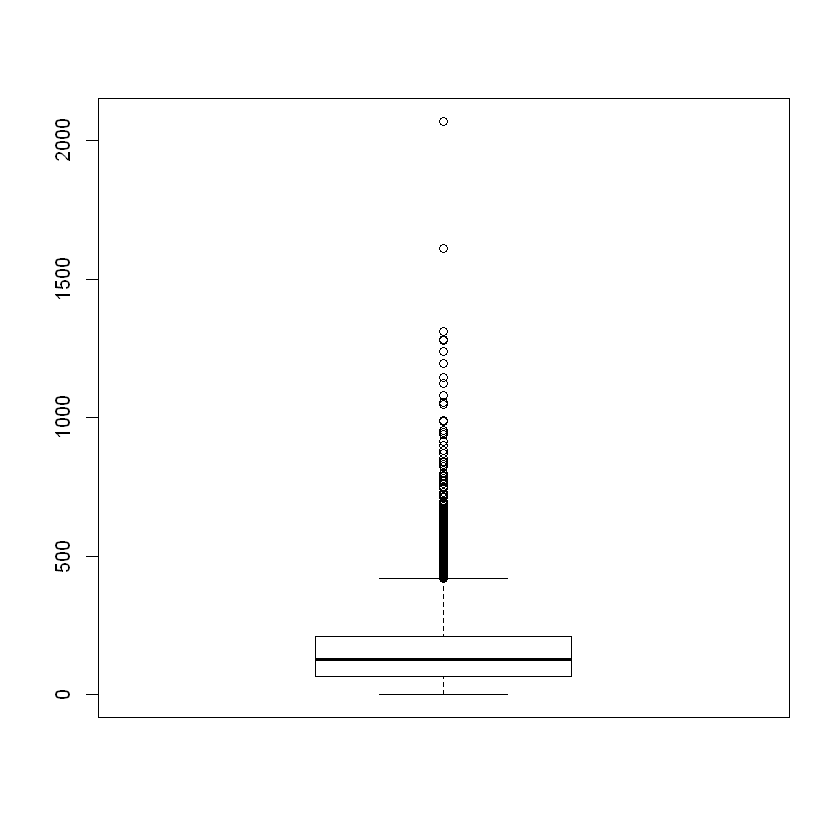

In [15]:
# BoxPlot e Histograma
boxplot(dataset_clientes$card2spent)

In [17]:
summary(dataset_clientes$card2spent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   66.97  125.34  160.88  208.31 2069.25 

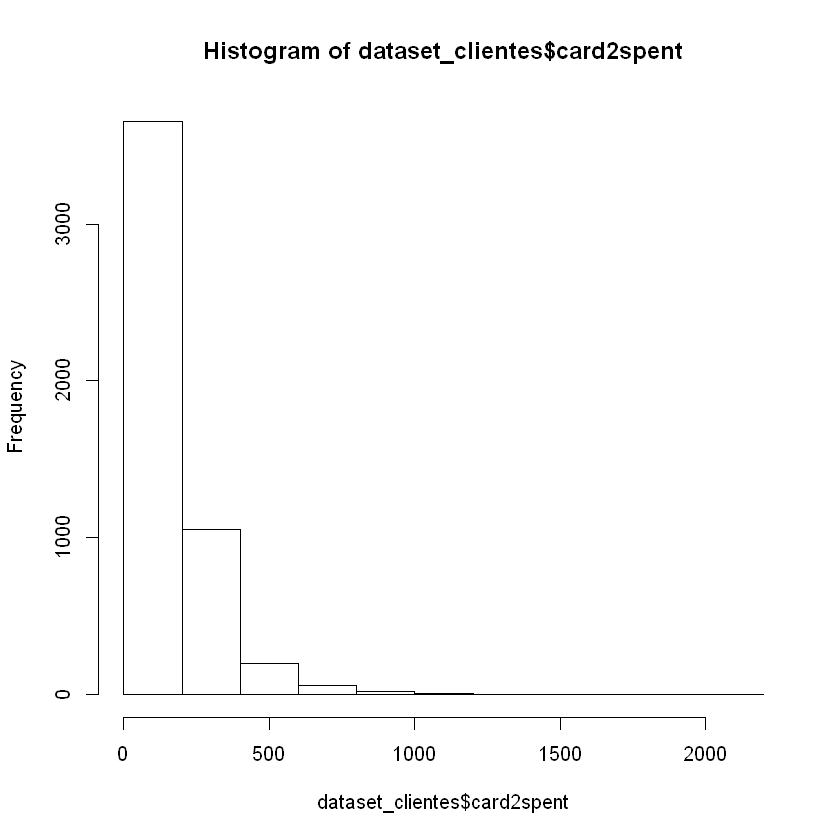

In [18]:
hist(dataset_clientes$card2spent)

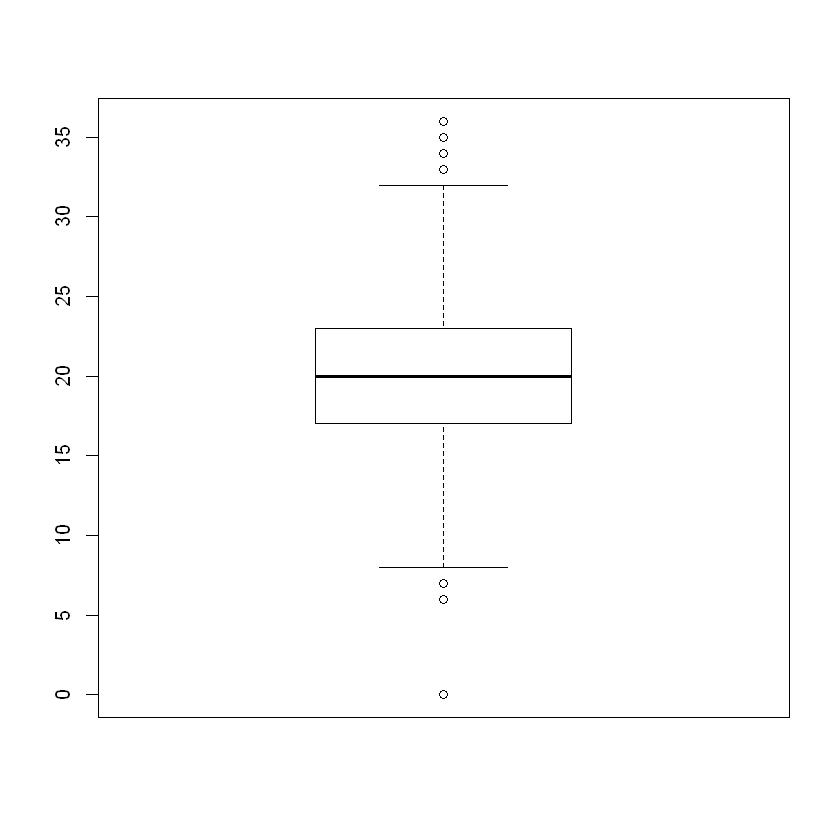

In [20]:
boxplot(dataset_clientes$hourstv)

In [21]:
summary(dataset_clientes$hourstv)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   17.00   20.00   19.64   23.00   36.00 

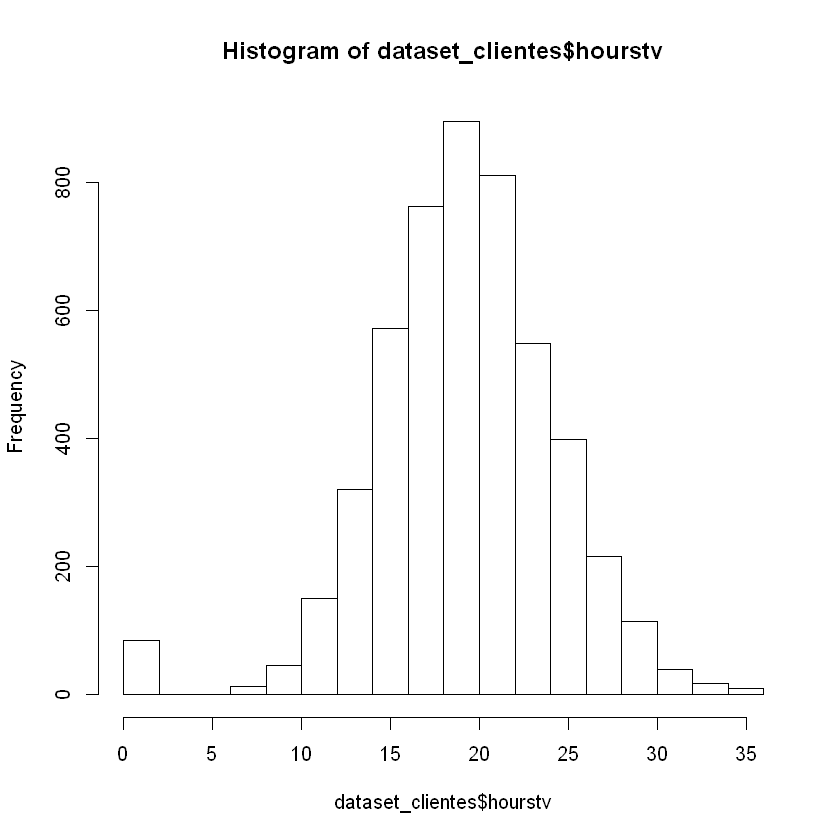

In [22]:
hist(dataset_clientes$hourstv)

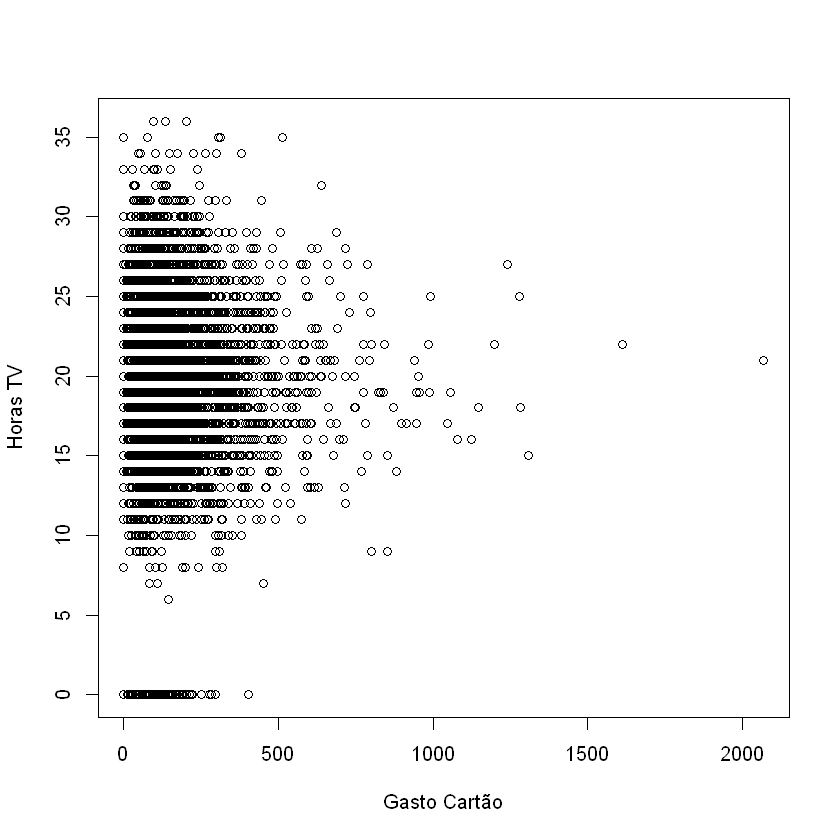

In [23]:
# Scatter Plot
plot(dataset_clientes$card2spent, dataset_clientes$hourstv, xlab = "Gasto Cartão", ylab = "Horas TV")